In [1]:
import os
import sys
sys.path.append("..")

In [2]:
os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "0"

In [3]:
%load_ext autoreload
%autoreload 2

# Fashion MNIST: Homoskedastic VAE

In [4]:
import jax
import optax
import distrax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from functools import partial
from flax.training import train_state
from torchvision.datasets import FashionMNIST
from typing import Callable

import vae
import linear_factor as lf_demo

## Create train dataset

In [5]:
root = "/tmp/fashion-mnist"
mnist_train = FashionMNIST(root, download=True, train=True)
mnist_test = FashionMNIST(root, download=True, train=False)

In [6]:
key = jax.random.PRNGKey(314)
key_fa_param, key_sample, key = jax.random.split(key, 3)
key_vae, key_test = jax.random.split(key)

In [7]:
n_train = 1000
n_test = 500

y_train = jnp.array(mnist_train.targets)

X_train = jnp.array(mnist_train.data)[:n_train + n_test]
X_train = X_train.reshape(-1, 28 ** 2)

y_train = y_train[:n_train + n_test]
dim_output = len(jnp.unique(y_train))

num_train, dim_obs = X_train.shape
# "Gaussanised" MNIST
# X_train = X_train[..., None]
xmax = X_train.max()

X_train = X_train / xmax

xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd

y_ohe_train = jax.nn.one_hot(y_train, dim_output)
num_samples = len(X_train)

X_test = X_train[-n_test:]
y_test = y_train[-n_test:]
y_ohe_test = y_ohe_train[-n_test:]

X_train = X_train[:-n_test]
y_train = y_train[:-n_test]
y_ohe_train = y_ohe_train[:-n_test]


X_train.shape

(1000, 784)

# VAE

In [65]:
class Decoder(nn.Module):
    """
    For the generative model
    p(x,z) = p(x|z) * p(z)
    """
    dim_full: int
    dim_latent: int = 20
    
    @nn.compact
    def __call__(self, z):
        x = nn.Dense(20)(z)
        x = nn.relu(x)
        mean_x = nn.Dense(self.dim_full)(x)
        logvar_x = nn.Dense(self.dim_full)(x)
        return mean_x, logvar_x
    
    
class HomkDecoder(nn.Module):
    """
    Parameterise the generative model
    p(x,z) = p(x|z) * p(z)
    as a homoskedastic generative process
    """
    dim_obs: int
    dim_latent: int = 20
    normal_init: Callable = nn.initializers.normal()
    
    def setup(self):
        self.logPsi = self.param("logPsi", self.normal_init, (self.dim_obs,))
    
    def eval_diag_cov(self, z):
        # logvar_x = jnp.einsum("...m,dm->...d", z, self.logPsi)
        zeros = jnp.zeros((self.dim_obs, self.dim_latent))
        logvar_x = jnp.einsum("...m,dm->...d", z, zeros) + self.logPsi

        return logvar_x


    @nn.compact
    def __call__(self, z):
        x = nn.Dense(30)(z)
        x = nn.relu(x)
        mean_x = nn.Dense(self.dim_obs, use_bias=True)(x)
        # logvar_x = nn.Dense(self.dim_obs, use_bias=False)(x)
        logvar_x = self.eval_diag_cov(z)
        
        return mean_x, logvar_x
    

class EncoderFullCov(nn.Module):
    """
    For the inference model p(z|x)
    """
    latent_dim: int
    n_hidden: int = 5

    def setup(self):
        init_tri = nn.initializers.normal(stddev=1e-5)
        # Number of elments in the lower (without diagonal) triangular matrix
        tril_dim = self.latent_dim * (self.latent_dim + 1) // 2 - self.latent_dim
        self.mean_layer = nn.Dense(self.latent_dim, name="latent_mean")
        self.logvardiag_layer = nn.Dense(self.latent_dim, use_bias=False, name="latent_logvardiag", kernel_init=init_tri)
        self.tril_layer  = nn.Dense(tril_dim, name="latent_tril", use_bias=False, kernel_init=init_tri)


    @nn.compact
    def __call__(self, x):
        z = nn.Dense(self.n_hidden, name="latent_hiddent_1")(x)
        z = nn.relu(z)

        mean_z = self.mean_layer(z)
        logvar_z = self.logvardiag_layer(z)
        
        import pdb; pdb.set_trace()
        diag_z = jax.vmap(jnp.diag)(jnp.exp(logvar_z / 2))
        # diag_z = jnp.diag(jnp.exp(logvar_z / 2))
        Lz = self.tril_layer(z)
        Lz = jax.vmap(vae.fill_lower_tri, (0, None))(Lz, self.latent_dim)

        return mean_z, Lz + diag_z
 

class VAEIW(nn.Module):
    """
    Importance-Weighted Variational Autoencoder
    """
    latent_dim: int
    full_dim: int
    Encoder: nn.Module
    Decoder: nn.Module
    n_hidden: int = 5
    
    @staticmethod
    def reparameterise(key, mean, logvar, num_samples=1):
        std = jnp.exp(logvar / 2)
        eps = jax.random.normal(key, (num_samples, *logvar.shape))
        z = mean[None, ...] + jnp.einsum("...d,...d->...d", std, eps)
        return z
    
    def setup(self):
        self.encoder = self.Encoder(self.latent_dim, self.n_hidden)
        self.decoder = self.Decoder(self.full_dim, self.latent_dim)
    
    def __call__(self, x, key_eps, num_samples=1):
        mean_z, logvar_z = self.encoder(x)
        z = VAEIW.reparameterise(key_eps, mean_z, logvar_z, num_samples)
        mean_x, logvar_x = self.decoder(z)
        return z, (mean_z, logvar_z), (mean_x, logvar_x)
    

class VAEIWFD(nn.Module):
    """
    Importance-Weighted Variational Autoencoder with Full Covariance Matrix
    for the posterior distribution
    """
    latent_dim: int
    full_dim: int
    n_hidden: int = 5
    
    def reparameterise(self, key, mean, cov, num_samples):
        num_obs = len(mean)
        eps = jax.random.normal(key, (num_samples, num_obs, self.latent_dim))
        z = mean + jnp.einsum("...dm,...m->...d", cov, eps)
        return z
    
    def setup(self):
        self.encoder = EncoderFullCov(self.latent_dim, self.n_hidden)
        self.decoder = Decoder(self.full_dim)
    
    def __call__(self, x, key_eps, num_samples=1):
        mean_z, L_z = self.encoder(x)
        z = self.reparameterise(key_eps, mean_z, L_z, num_samples)
        mean_x, logvar_x = self.decoder(z)
        return z, (mean_z, L_z), (mean_x, logvar_x)

## Diagonal covariance matrix

In [225]:
key_params_init, key_eps_init, key_train = jax.random.split(key_vae, 3)

In [230]:
dim_latent = 50
batch_size = 1000
n_epochs = 2000

In [231]:
n_hidden = 100
batch_init = jnp.ones((batch_size, dim_obs))

model = VAEIW(dim_latent, dim_obs, vae.Encoder, HomkDecoder, n_hidden)

params_init = model.init(key_params_init, batch_init, key_eps_init, num_samples=3)
opt_state = tx.init(params_init)

In [232]:
tx = optax.adam(1e-3)
state = train_state.TrainState.create(
    apply_fn=partial(model.apply, num_samples=50),
    params=params_init,
    tx=tx
)

In [233]:
def iwae(key, params, apply_fn, X_batch):
    """
    Loss function
    -------------
    
    Importance-weight Variational Autoencoder (IW-VAE)
    """
    batch_size = len(X_batch)
    keys = jax.random.split(key, batch_size)
    
    encode_decode = jax.vmap(apply_fn, (None, 0, 0))
    encode_decode = encode_decode(params, X_batch, keys)
    z, (mean_z, logvar_z), (mean_x, logvar_x) = encode_decode
    _, num_is_samples, *_ = z.shape
    
    std_z = jnp.exp(logvar_z / 2)
    std_x = jnp.exp(logvar_x / 2)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(model.latent_dim),
                                                jnp.ones(model.latent_dim))
    dist_decoder = distrax.MultivariateNormalDiag(mean_x, std_x)
    dist_posterior = distrax.Normal(mean_z[:, None, :], std_z[:, None, :])
    
    log_prob_z_prior = dist_prior.log_prob(z)
    log_prob_x = dist_decoder.log_prob(X_batch[:, None, :])
    log_prob_z_post = dist_posterior.log_prob(z).sum(axis=-1)
    
    log_prob = log_prob_z_prior + log_prob_x - log_prob_z_post
    
    # negative Importance-weighted marginal log-likelihood
    niwmll = -jax.nn.logsumexp(log_prob, axis=-1, b=1/num_is_samples).sum()
    return niwmll


@partial(jax.jit, static_argnames=("tx", "model", "lossfn"))
def train_step(state, X, key, tx, lossfn, model):
    params = state.params
    apply_fn = state.apply_fn
    
    loss, grads = jax.value_and_grad(lossfn, 1)(key, params, apply_fn, X)
    new_state = state.apply_gradients(grads=grads)
    return loss, new_state


def train_epoch(key, state, X, batch_size):
    num_samples = len(X)
    key_batch, keys_vae = jax.random.split(key)
    batch_ixs = vae.get_batch_train_ixs(key_batch, num_samples, batch_size)
    
    num_batches = len(batch_ixs)
    keys_vae = jax.random.split(keys_vae, num_batches)
    
    total_loss = 0
    for key_vae, batch_ix in zip(keys_vae, batch_ixs):
        X_batch = X[batch_ix, ...]
        loss, state = train_step(state, X_batch, key_vae, tx=tx, model=model, lossfn=iwae)
        total_loss += loss
    
    return total_loss.item(), state

In [234]:
keys_train = jax.random.split(key_train, n_epochs)
hist_loss = []
hist_mll_vae_iw_full = []

loss_old = -jnp.inf
for e, keyt in (pbar := tqdm(enumerate(keys_train), total=len(keys_train))):
    loss, state = train_epoch(keyt, state, samples_observed, batch_size)
    
    hist_loss.append(loss)
        
    pbar.set_description(f"{loss=:.3e}")
params_final = state.params

  0%|          | 0/2000 [00:00<?, ?it/s]

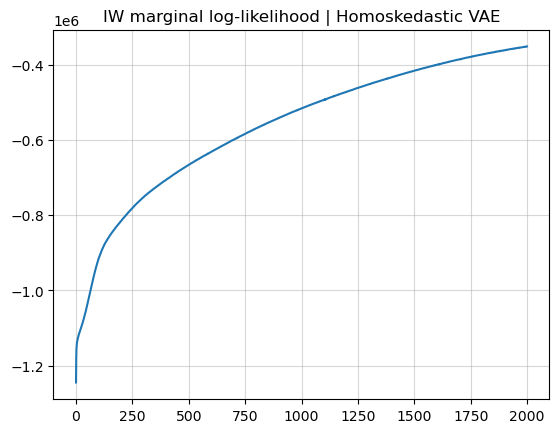

In [219]:
plt.title("IW marginal log-likelihood | Homoskedastic VAE")
plt.plot(hist_mll_vae)
plt.grid(alpha=0.5)

In [222]:
hist_mll_vae = -jnp.array(hist_loss)
format(hist_mll_vae[-1], ".3e")

'-2.297e+05'

In [49]:
%store hist_mll_vae

Stored 'hist_mll_vae' (DeviceArray)


In [220]:
n_samples = 7
key_samples, _ = jax.random.split(key_test)
key_samples = jax.random.split(key_samples, n_samples)

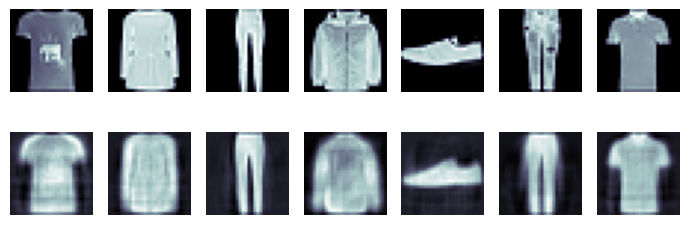

In [221]:
# ixs_test = jax.random.choice(key_test, len(X_train), (n_samples,))
ixs_test = jnp.array([180, 609, 761, 555, 119, 599, 219])

fig, ax = plt.subplots(2, n_samples, figsize=(7.0, 3.0))

for ax, ix in zip(ax.T, ixs_test):
    obs = X_train[ix]
    z, (mean_z, L_z), (mean_x, logvar_x) = model.apply(params_final, obs, key_train)

    ax[0].imshow(obs.reshape(28, 28), cmap="bone")
    ax[1].imshow(mean_x.reshape(28, 28), cmap="bone")
    ax[0].axis("off")
    ax[1].axis("off")
plt.tight_layout()